# Analysis of Failed IDs and Raw ECG Quality

This notebook identifies subjects that failed the feature extraction pipeline, analyzes the reasons for failure (signal quality, missing files, flatlines), and performs Exploratory Data Analysis (EDA) on the raw signal characteristics.

In [9]:
import os
import glob
import pandas as pd
import numpy as np
import wfdb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import neurokit2 as nk

plt.style.use('ggplot')

## 1. Define Paths and Load Metadata

In [10]:
# Adjust paths relative to this notebook location (src/Data_processing/eda/eda_raw_data)
RAW_DIR = r"../../../../data/raw/autonomic-aging-a-dataset"
SB_GROUP_PATH = r"../../../../data/processed/Age_group_reduced.csv"
PROCESSED_DATA_PATH = r"../../../../data/processed/seg_300s/data_300s_order5.csv"

# Load Metadata (All expected subjects)
df_meta = pd.read_csv(SB_GROUP_PATH, dtype={'ID': str})
print(f"Total Subjects in Metadata: {len(df_meta)}")

# Load Processed Data (Successfully extracted)
if os.path.exists(PROCESSED_DATA_PATH):
    df_processed = pd.read_csv(PROCESSED_DATA_PATH, dtype={'ID': str})
    print(f"Total Subjects Successfully Processed: {df_processed['ID'].nunique()}")
else:
    print("Processed file not found. Assuming 0 processed.")
    df_processed = pd.DataFrame(columns=['ID'])

Total Subjects in Metadata: 1093
Total Subjects Successfully Processed: 1044


## 2. Identify Missing IDs

In [11]:
all_ids = set(df_meta['ID'])
processed_ids = set(df_processed['ID'])
missing_ids = list(all_ids - processed_ids)
missing_ids.sort()

print(f"Number of Missing/Failed IDs: {len(missing_ids)}")
print(f"Missing IDs: {missing_ids[:20]} ..." if len(missing_ids) > 20 else f"Missing IDs: {missing_ids}")

Number of Missing/Failed IDs: 49
Missing IDs: ['0002', '0007', '0047', '0068', '0092', '0134', '0144', '0186', '0249', '0254', '0273', '0276', '0300', '0320', '0323', '0332', '0365', '0373', '0400', '0405'] ...


## 3. Analyze Failure Reasons
We will scan the raw files for the missing IDs to check for:
- File existence
- Zero Variance (Flatline)
- Excessive NaNs
- Extremely short duration

In [12]:
scan_results = []

for rec_id in tqdm(missing_ids, desc="Scanning Failed IDs"):
    path = os.path.join(RAW_DIR, rec_id)
    # Initialize default values safely
    res = {
        'ID': rec_id,
        'Exists': False,
        'Duration_min': 0.0,
        'Fs': 0,
        'NaN_Count': 0,
        'Variance': 0.0,
        'Reason': 'Unknown'
    }
    
    # Check if header exists
    if not os.path.exists(path + ".hea"):
        res['Reason'] = "File Not Found"
        scan_results.append(res)
        continue
        
    res['Exists'] = True
    try:
        record = wfdb.rdrecord(path)
        if record.p_signal is None:
             res['Reason'] = "Signal None"
             scan_results.append(res)
             continue
             
        sig = record.p_signal[:, 0]
        fs = record.fs
        
        res['Fs'] = fs
        # Calculate Duration safely
        if fs > 0:
            res['Duration_min'] = len(sig) / fs / 60.0
        else:
            res['Duration_min'] = 0.0
            
        res['NaN_Count'] = np.isnan(sig).sum()
        res['Variance'] = np.var(sig)
        
        # Determine Reason
        if len(sig) == 0:
            res['Reason'] = "Empty Signal"
        elif res['NaN_Count'] == len(sig):
            res['Reason'] = "All NaNs"
        elif res['Variance'] == 0:
            res['Reason'] = "Flatline (Zero Var)"
        elif res['Variance'] < 1e-6:
            res['Reason'] = "Near Flatline"
        elif res['Duration_min'] < 5.0:
             res['Reason'] = "Too Short (<5 min)"
        else:
            # Try Quick Peak Detection Check
            try:
                ecg_clean = nk.signal_filter(sig, sampling_rate=fs, lowcut=0.5, method="butterworth", order=5)
                peaks, _ = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
                if len(peaks) < 10:
                    res['Reason'] = "No/Few Peaks Detected"
                else:
                    res['Reason'] = "Processing Error (Unknown)"
            except Exception as e_peak:
                res['Reason'] = f"Peak Det Crash: {str(e_peak)}"
                
    except Exception as e:
        res['Reason'] = f"Read Error: {str(e)}"
    
    scan_results.append(res)

df_scan = pd.DataFrame(scan_results)

Scanning Failed IDs:   0%|          | 0/49 [00:00<?, ?it/s]

d:\App\anaconda3\envs\Cardioformer\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\App\anaconda3\envs\Cardioformer\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\App\anaconda3\envs\Cardioformer\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\App\anaconda3\envs\Cardioformer\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\App\anaconda3\envs\Cardioformer\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\App\anaconda3\envs\Cardioformer\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountere

## 4. Summary of Failure Reasons

Failure Reason Distribution:
Reason
Processing Error (Unknown)                                                                                                                              48
Read Error: [Errno 2] No such file or directory: 'd:/OneDrive/Desktop/The big project/ecg-ordinal-aging/data/raw/autonomic-aging-a-dataset/0400.dat'     1
Name: count, dtype: int64


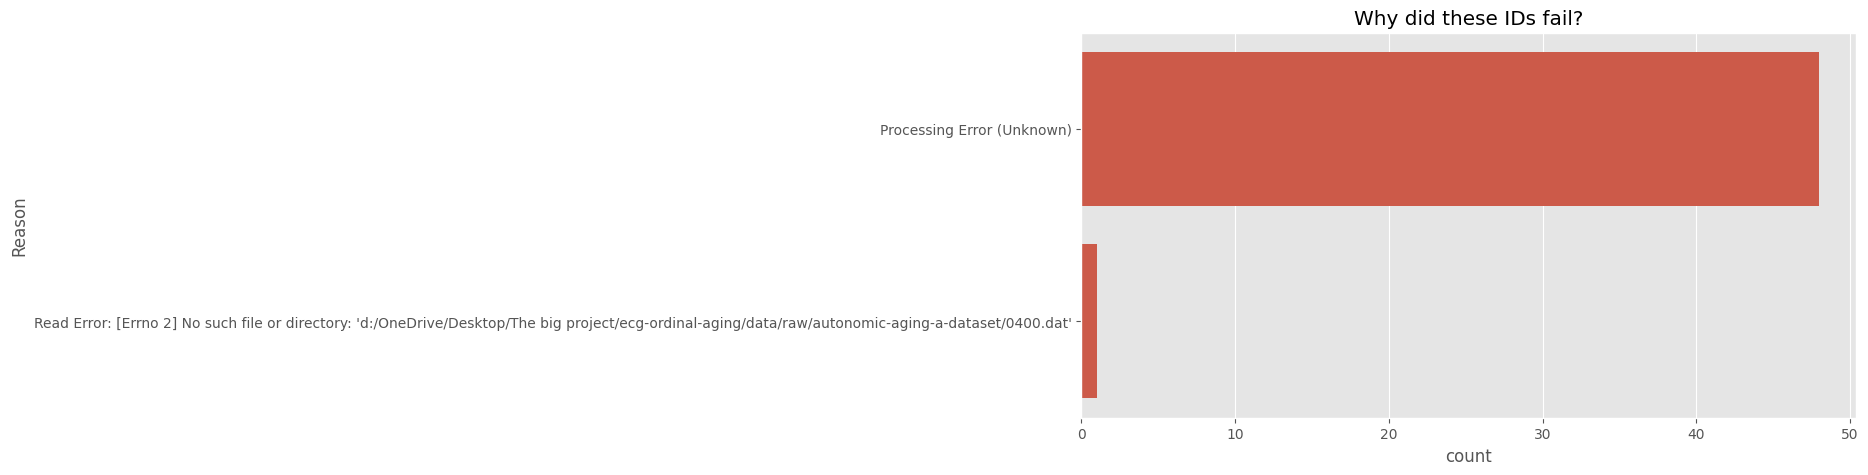

In [13]:
print("Failure Reason Distribution:")
print(df_scan['Reason'].value_counts())

plt.figure(figsize=(10, 5))
sns.countplot(y='Reason', data=df_scan, order=df_scan['Reason'].value_counts().index)
plt.title("Why did these IDs fail?")
plt.show()

## 5. Detailed List of Failed IDs (Sorted by Severity)
Sorting Criteria: 
1. Reason (Grouped)
2. Variance (Low is bad)
3. NaN Count (High is bad)

In [14]:
# Start with most "obvious" failures like Flatlines and NaNs
df_scan_sorted = df_scan.sort_values(by=['Reason', 'Variance', 'NaN_Count'], ascending=[True, True, False])

print("Top 20 Problematic Files:")
display(df_scan_sorted.head(20))

# Export to CSV if needed
# df_scan_sorted.to_csv("failed_ids_analysis.csv", index=False)

Top 20 Problematic Files:


,ID,Exists,Duration_min,Fs,NaN_Count,Variance,Reason
22,0455,True,15.025017,1000,0,0.015583,Processing Error (Unknown)
11,0276,True,15.041683,1000,0,0.019558,Processing Error (Unknown)
6,0144,True,15.025017,1000,0,0.019938,Processing Error (Unknown)
3,0068,True,15.046683,1000,0,0.028135,Processing Error (Unknown)
28,0507,True,15.088350,1000,0,0.031098,Processing Error (Unknown)
35,0747,True,14.996683,1000,0,0.031120,Processing Error (Unknown)
5,0134,True,15.188350,1000,0,0.033375,Processing Error (Unknown)
34,0637,True,8.008350,1000,0,0.033573,Processing Error (Unknown)
37,0802,True,10.006683,1000,0,0.033710,Processing Error (Unknown)
44,0967,True,15.008350,1000,0,0.035477,Processing Error (Unknown)


## 6. General EDA: Compare Failed vs Processed Populations
Are failed subjects biased by Age or Sex?

ValueError: Could not interpret value `Age_group` for `x`. An entry with this name does not appear in `data`.

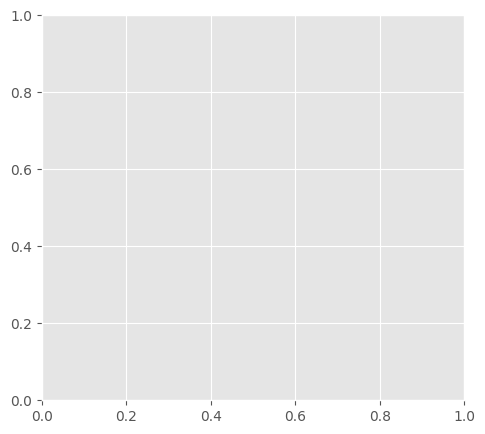

In [15]:
df_meta['Status'] = df_meta['ID'].apply(lambda x: 'Processed' if x in processed_ids else 'Failed')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Age_group', hue='Status', data=df_meta)
plt.title("Failures by Age Group")

plt.subplot(1, 2, 2)
if 'Sex' in df_meta.columns:
    sns.countplot(x='Sex', hue='Status', data=df_meta)
    plt.title("Failures by Sex")
else:
    plt.text(0.5, 0.5, 'Sex column missing in Metadata', ha='center')

plt.tight_layout()
plt.show()

## 7. Visualize Random Failed Signals
Plotting a few random failed signals to visually verify the issues.

In [ ]:
failed_sample = df_scan[df_scan['Exists'] == True].sample(min(5, len(df_scan)))

for _, row in failed_sample.iterrows():
    rec_id = row['ID']
    reason = row['Reason']
    path = os.path.join(RAW_DIR, rec_id)
    try:
        record = wfdb.rdrecord(path)
        sig = record.p_signal[:, 0]
        fs = record.fs
        
        plt.figure(figsize=(12, 3))
        # Plot max 10 seconds
        limit = min(len(sig), 10 * fs)
        plt.plot(np.arange(limit)/fs, sig[:limit])
        plt.title(f"ID: {rec_id} | Reason: {reason} | Var: {row['Variance']:.5f}")
        plt.xlabel("Time (s)")
        plt.show()
    except:
        pass